# 4. Recovery of dysregulated elements in response to cancer mutations

In this vignette, we will explore another way to evaluate networks, this time using a more biological approach. We will use the Clinical Proteomic Tumor Analysis Consortium (CPTAC) data, a compendium of tissue samples from 10 different cancer types, along with their respective adjacent, healthy tissue, samples.
> Ellis, M. J. et al. Connecting genomic alterations to cancer biology with proteomics: the NCI Clinical Proteomic Tumor Analysis Consortium. Cancer Discov. 3, 1108–1112 (2013).

> Li, Y. et al. Proteogenomic data and resources for pan-cancer analysis. Cancer Cell 41, 1397–1406 (2023).


In this setting, we will use a multiomics approach as follows:
* First, we will identify the most differentially abundant receptors in the proteomics profiles between healthy and tumor samples. We assume that if they are differentially abundant, they will be activated/inhibited.
* Second, we will use the transcriptomics data to perform TF enrichment analysis, in order to get the TFs that are dysregulated in the tumor samples compared to the healthy control.
* Lastly, we will use phosphoproteomics to evaluate the level of dysregulation in the resulting subnetwork, and assess whether these subnetworks contain a higher share of dysregulated elements compared to the overall phosphoproteome.

## 1. Data processing

In [1]:
import networkcommons as nc
import pandas as pd
import numpy as np

NetworkCommons provide a series of util functions to retrieve the CPTAC tables in an easy way. We can use the `cptac_cohorsize()` function to visualise the different cancer samples, and the `cptac_fileinfo()` function to visualise the different files. Finally, we will get the tables using the `cptac_table()` function.

In [2]:
nc.data.omics.datasets()

{'decryptm': 'Drug perturbation proteomics and phosphoproteomics data',
 'panacea': 'Pancancer Analysis of Chemical Entity Activity RNA-Seq data',
 'test': 'Small RNA-Seq data for unit tests',
 'moon': 'Database files for running MOON',
 'cosmos': 'Database files for running COSMOS (MetaPKN)',
 'CPTAC': 'Clinical Proteomic Tumor Analysis Consortium data'}

In [3]:
nc.data.omics.cptac_cohortsize()

,Cancer_type,Tumor,Normal
0,BRCA,122,0
1,CCRCC,103,80
2,COAD,110,100
3,GBM,99,0
4,HNSCC,108,62
5,LSCC,108,99
6,LUAD,110,101
7,OV,83,20
8,PDAC,105,44
9,UCEC,95,18


In [4]:
nc.data.omics.cptac_fileinfo()

,File name,Description
0,XXXX_methylation_gene_meta_value_Normal.txt,"Methylation, gene level meta value, normal samples"
1,XXXX_methylation_gene_meta_value_Tumor.txt,"Methylation, gene level meta value, tumor samples"
2,XXXX_miRNAseq_mature_miRNA_RPM_log2_Normal.txt,"miRNAseq, Log2(mature miRNA RPM) of normal samples"
3,XXXX_miRNAseq_mature_miRNA_RPM_log2_Tumor.txt,"miRNAseq, Log2(mature miRNA RPM) of tumor samples"
4,XXXX_phospho_site_abundance_log2_reference_intensity_normalized_Normal.txt,"Phosphoproteomics, Log2(phospho site MS1 intensity), reference intensity normalized, isoform adjusted, normal samples"
5,XXXX_phospho_site_abundance_log2_reference_intensity_normalized_Tumor.txt,"Phosphoproteomics, Log2(phospho site MS1 intensity), reference intensity normalized, isoform adjusted, tumor samples"
6,XXXX_proteomics_gene_abundance_log2_reference_intensity_normalized_Normal.txt,"Global proteomics, Log2(gene level MS1 intensity), reference intensity normalized, normal samples"
7,XXXX_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.txt,"Global proteomics, Log2(gene level MS1 intensity), reference intensity normalized, tumor samples"
8,XXXX_RNAseq_circRNA_RSEM_UQ_log2_Normal.txt,"RNAseq, Log2(circRNA RSEM), UQ normalized by linear gene expression, normal samples"
9,XXXX_RNAseq_circRNA_RSEM_UQ_log2_Tumor.txt,"RNAseq, Log2(circRNA RSEM), UQ normalized by linear gene expression, tumor samples"


In [5]:
nc.data.omics.cptac_datatypes()


['metadata', 'methylation', 'mirna', 'phosphoproteome', 'proteome', 'rna']

In [6]:
cptac_transcriptomics_tumor = nc.data.omics.cptac_table('rna', 'LSCC', 'RNAseq_gene_RSEM_coding_UQ_1500_log2_Tumor')
cptac_proteomics_tumor = nc.data.omics.cptac_table('proteome', 'LSCC', 'proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor')
cptac_phosphoproteomics_tumor = nc.data.omics.cptac_table('phosphoproteome', 'LSCC', 'phospho_site_abundance_log2_reference_intensity_normalized_Tumor')
cptac_transcriptomics_ctrl = nc.data.omics.cptac_table('rna', 'LSCC', 'RNAseq_gene_RSEM_coding_UQ_1500_log2_Normal')
cptac_proteomics_ctrl = nc.data.omics.cptac_table('proteome', 'LSCC', 'proteomics_gene_abundance_log2_reference_intensity_normalized_Normal')
cptac_phosphoproteomics_ctrl = nc.data.omics.cptac_table('phosphoproteome', 'LSCC', 'phospho_site_abundance_log2_reference_intensity_normalized_Normal')
cptac_meta = nc.data.omics.cptac_table('metadata', 'LSCC', 'meta')

In [27]:
transcriptomics = pd.merge(cptac_transcriptomics_ctrl, cptac_transcriptomics_tumor, left_on='idx', right_on='idx', how='outer', suffixes=('_ctrl', '_tumor'))
proteomics = pd.merge(cptac_proteomics_ctrl, cptac_proteomics_tumor, left_on='idx', right_on='idx', how='outer', suffixes=('_ctrl', '_tumor'))
phosphoproteomics = pd.merge(cptac_phosphoproteomics_ctrl, cptac_phosphoproteomics_tumor, left_on='idx', right_on='idx', how='outer', suffixes=('_ctrl', '_tumor'))

In [8]:
transcriptomics_meta = pd.DataFrame({'sample': transcriptomics.set_index('idx').columns.to_list()})
transcriptomics_meta['group'] = transcriptomics_meta['sample'].apply(lambda x: 'ctrl' if '_ctrl' in x else 'tumor')

In [9]:
proteomics_meta = pd.DataFrame({'sample': proteomics.set_index('idx').columns.to_list()})
proteomics_meta['group'] = proteomics_meta['sample'].apply(lambda x: 'ctrl' if '_ctrl' in x else 'tumor')

In [10]:
phosphoproteomics_meta = pd.DataFrame({'sample': phosphoproteomics.set_index('idx').columns.to_list()})
phosphoproteomics_meta['group'] = phosphoproteomics_meta['sample'].apply(lambda x: 'ctrl' if '_ctrl' in x else 'tumor')

In [11]:
transcriptomics.head()

,idx,C3L-00081_ctrl,C3L-00415_ctrl,C3L-00445_ctrl,C3L-00568_ctrl,C3L-00603_ctrl,C3L-00904_ctrl,C3L-00923_ctrl,C3L-00927_ctrl,C3L-00993_ctrl,...,C3N-03851_tumor,C3N-03875_tumor,C3N-03877_tumor,C3N-03880_tumor,C3N-03882_tumor,C3N-03886,C3N-04124_tumor,C3N-04127_tumor,C3N-04155,C3N-04162_tumor
0,ENSG00000000003.15,9.1619,9.3218,8.8822,8.8718,9.6118,10.4317,9.9718,8.6323,9.3118,...,10.0918,10.5617,10.7817,9.6418,11.4716,10.4017,9.7217,10.4517,9.9219,11.0117
1,ENSG00000000005.6,1.4765,1.9343,1.7468,0.9565,0.9042,1.8829,1.8178,1.7328,0.0000,...,1.4384,1.3214,1.0009,1.5088,2.7509,1.1369,1.0160,1.9121,0.7763,1.4765
2,ENSG00000000419.12,9.4618,9.5618,9.4020,9.1718,9.3219,9.2818,9.3819,9.2020,9.3118,...,10.3017,9.9618,10.1117,9.7218,10.7817,9.7016,9.9217,10.9117,9.7019,9.2119
3,ENSG00000000457.14,9.7718,9.8017,9.2320,9.6418,9.8818,9.8818,9.8018,9.5219,9.3618,...,9.7618,10.0418,10.1617,10.2317,9.7218,11.4818,9.9317,9.6118,9.1322,9.8518
4,ENSG00000000460.17,7.8223,8.3819,8.0227,7.8720,8.0723,8.0322,8.1723,7.5332,7.7722,...,9.8118,9.0621,10.6017,9.7518,9.5219,11.6618,9.3917,8.7419,9.1921,9.6418


In [12]:
phosphoproteomics.head()

,idx,C3L-02665_ctrl,C3L-01663_ctrl,C3N-02575_ctrl,C3L-02546_ctrl,C3L-02963_ctrl,C3N-04162_ctrl,C3L-02646_ctrl,C3N-02285_ctrl,C3N-03875_ctrl,...,C3N-03425_tumor,C3L-02163_tumor,C3N-04124_tumor,C3L-00904_tumor,C3N-00211,C3N-01892_tumor,C3L-00603_tumor,C3L-03965_tumor,C3N-03851_tumor,C3L-02349_tumor
0,ENSG00000000419.12|ENSP00000360644.5|S21|RRELEVRSPRQNKYS|1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000000457.14|ENSP00000356746.4|S533|SEEWPDWSEPEEPEN|1,20.15139,20.518985,20.12092,19.524927,NaN,20.197389,20.428171,NaN,19.430541,...,19.894803,20.270334,20.555754,20.636069,20.059452,19.963673,19.312416,19.589386,20.048120,20.029813
2,ENSG00000000457.14|ENSP00000356746.4|S558|EPCDDVKSQCTTLDV|1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15.781297,14.657933,14.248313,14.958611,15.152006
3,ENSG00000000457.14|ENSP00000356746.4|S569|TLDVEESSWDDCEPS|1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.551497,19.657661,20.039314,20.200392,20.044415,19.576859,18.991163,18.908664,19.818676,19.886261
4,ENSG00000000457.14|ENSP00000356746.4|S577|WDDCEPSSLDTKVNP|1,NaN,NaN,NaN,NaN,17.802051,18.106032,16.735936,17.474137,18.096801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since NAs in proteomics and phosphoproteomics are quite ubiquitous, we use a filling strategy using the mean for those elements which have less than 10% of the values missing. Otherwise, we remove the row.

In [13]:
transcriptomics = nc.utils.handle_missing_values(transcriptomics)

Number of genes filled: 0
Number of genes removed: 0


In [14]:
proteomics = nc.utils.handle_missing_values(proteomics)

Number of genes filled: 802
Number of genes removed: 3318


In [28]:
phosphoproteomics

,idx,C3L-02665_ctrl,C3L-01663_ctrl,C3N-02575_ctrl,C3L-02546_ctrl,C3L-02963_ctrl,C3N-04162_ctrl,C3L-02646_ctrl,C3N-02285_ctrl,C3N-03875_ctrl,...,C3N-03425_tumor,C3L-02163_tumor,C3N-04124_tumor,C3L-00904_tumor,C3N-00211,C3N-01892_tumor,C3L-00603_tumor,C3L-03965_tumor,C3N-03851_tumor,C3L-02349_tumor
0,ENSG00000000419.12|ENSP00000360644.5|S21|RRELEVRSPRQNKYS|1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000000457.14|ENSP00000356746.4|S533|SEEWPDWSEPEEPEN|1,20.15139,20.518985,20.12092,19.524927,NaN,20.197389,20.428171,NaN,19.430541,...,19.894803,20.270334,20.555754,20.636069,20.059452,19.963673,19.312416,19.589386,20.048120,20.029813
2,ENSG00000000457.14|ENSP00000356746.4|S558|EPCDDVKSQCTTLDV|1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15.781297,14.657933,14.248313,14.958611,15.152006
3,ENSG00000000457.14|ENSP00000356746.4|S569|TLDVEESSWDDCEPS|1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.551497,19.657661,20.039314,20.200392,20.044415,19.576859,18.991163,18.908664,19.818676,19.886261
4,ENSG00000000457.14|ENSP00000356746.4|S577|WDDCEPSSLDTKVNP|1,NaN,NaN,NaN,NaN,17.802051,18.106032,16.735936,17.474137,18.096801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65476,ENSG00000284791.2|ENSP00000493663.2|S93|GEDGDDDS_______|1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65477,ENSG00000284862.3|ENSP00000417960.2|S896|ARSSRSTSTSTSQSS|1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65478,ENSG00000286140.1|ENSP00000305687.6|S302|ASGNMGTSPSSMARV|1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,19.136131,18.617529,18.386632,19.304861,18.689828
65479,ENSG00000286140.1|ENSP00000305687.6|S70|TPFPRNPSPFPASSG|1,NaN,NaN,NaN,NaN,21.702537,22.120549,21.648293,22.222580,21.795100,...,20.806658,21.750930,21.409648,22.273421,22.097232,21.202357,19.961261,21.397798,22.165360,21.568517


In [29]:
phosphoproteomics[['gene', 'prot', 'psite', 'seq', 'n']] = phosphoproteomics['idx'].str.split('|', expand=True)


In [30]:
phosphoproteomics.drop('idx', inplace=True, axis=1)

In [31]:
ensembl_table = nc.data.omics.get_ensembl_mappings()

In [32]:
ensembl_table

,gene_symbol,ensembl_id
0,MT-TF,ENST00000387314
1,MT-RNR1,ENST00000389680
2,MT-TV,ENST00000387342
3,MT-RNR2,ENST00000387347
4,MT-TL1,ENST00000386347
...,...,...
409893,FLG2,ENSP00000373370
409894,DUSP10,ENSP00000355866
409895,DUSP10,ENSP00000483812
409896,DUSP10,ENSP00000482935


In [50]:
def convert_ensembl_to_gene_symbol(dataframe, equivalence_df, column_name='idx', summarisation='mean'):
    """
    Converts Ensembl IDs to gene symbols using an equivalence dataframe, handles partial matches, 
    and summarizes duplicated entries by taking the maximum value.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe with Ensembl IDs.
        equivalence_df (pd.DataFrame): The equivalence dataframe with Ensembl IDs as index and gene symbols.
        You can either use a custom one or use the one retrieved by get_ensembl_mappings().
        column_name (str): The name of the column containing Ensembl IDs in the input dataframe.
        summarisation (str): The method to summarize duplicated entries. Options are 'max', 'min', 'mean', and 'median'.

    Returns:
        pd.DataFrame: The dataframe with gene symbols and summarized duplicated entries.
    """
    dataframe = dataframe.copy()
    equivalence_df = equivalence_df.copy()

    if column_name not in dataframe.columns:
        dataframe.reset_index(inplace=True)

    # Extract partial match from the Ensembl IDs in the input dataframe
    dataframe['partial_id'] = dataframe[column_name].str.extract(r'([A-Za-z0-9]+)', expand=False)

    # Reset index of equivalence dataframe for merging
    # Merge dataframes using partial matches
    merged_df = pd.merge(dataframe, equivalence_df, left_on='partial_id', right_on='ensembl_id', how='left')

    # Calculate and print the number and percentage of non-matched Ensembl IDs
    total_count = len(merged_df)
    non_matched_count = merged_df['gene_symbol'].isna().sum()
    non_matched_percentage = (non_matched_count / total_count) * 100
    print(f"Number of non-matched Ensembl IDs: {non_matched_count} ({non_matched_percentage:.2f}%)")

    # Drop temporary and original index columns
    merged_df.drop(columns=['partial_id', 'ensembl_id', column_name], inplace=True)

    # Summarize duplicated entries by taking the max value
    non_numeric_cols = merged_df.select_dtypes(exclude='number').columns.values
    print(non_numeric_cols)

    if summarisation == 'max':
        summarized_df = merged_df.groupby(list(non_numeric_cols)).max().reset_index()
    elif summarisation == 'min':
        summarized_df = merged_df.groupby(list(non_numeric_cols)).min().reset_index()
    elif summarisation == 'mean':
        summarized_df = merged_df.groupby(list(non_numeric_cols)).mean().reset_index()
    elif summarisation == 'median':
        summarized_df = merged_df.groupby(list(non_numeric_cols)).median().reset_index()
    else:
        raise ValueError(f"Invalid summarisation method: {summarisation}")

    # Calculate and print the number and percentage of summarized duplicated entries
    summarized_count = len(merged_df) - len(summarized_df)
    summarized_percentage = (summarized_count / total_count) * 100
    print(f"Number of summarized duplicated entries: {summarized_count} ({summarized_percentage:.2f}%)")

    return summarized_df

In [51]:
convert_ensembl_to_gene_symbol(phosphoproteomics, ensembl_table, column_name='gene')

Number of non-matched Ensembl IDs: 73 (0.11%)
['prot' 'psite' 'seq' 'n' 'gene_symbol']
Number of summarized duplicated entries: 73 (0.11%)


,prot,psite,seq,n,gene_symbol,C3L-02665_ctrl,C3L-01663_ctrl,C3N-02575_ctrl,C3L-02546_ctrl,C3L-02963_ctrl,...,C3N-03425_tumor,C3L-02163_tumor,C3N-04124_tumor,C3L-00904_tumor,C3N-00211,C3N-01892_tumor,C3L-00603_tumor,C3L-03965_tumor,C3N-03851_tumor,C3L-02349_tumor
0,ENSP00000000412.3,S267,DDQLGEESEERDDHL,1,M6PR,24.778932,24.144195,24.245553,24.187865,23.991156,...,24.531595,24.449057,23.827787,24.628376,24.798447,24.181133,24.707735,24.829209,24.645253,24.593752
1,ENSP00000000442.6,S19,YIKAEPASPDSPKGS,1,ESRRA,NaN,NaN,NaN,NaN,NaN,...,16.686672,15.722971,15.936290,16.567799,17.169873,NaN,NaN,NaN,NaN,NaN
2,ENSP00000000442.6,S22,AEPASPDSPKGSSET,1,ESRRA,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ENSP00000000442.6,S26,SPDSPKGSSETETEP,1,ESRRA,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ENSP00000000442.6,S27,PDSPKGSSETETEPP,1,ESRRA,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65403,ENSP00000501528.1,S184,LQTNKSGSGTMNLGG,1,CAPZB,NaN,NaN,NaN,NaN,19.636905,...,18.082416,18.748428,19.054349,19.280364,19.513818,NaN,NaN,NaN,NaN,NaN
65404,ENSP00000501528.1,S192,GTMNLGGSLTRQMEK,1,CAPZB,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65405,ENSP00000501528.1,S226,DMENKIRSTLNEIYF,1,CAPZB,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65406,ENSP00000501528.1,S263,KQLQRELSQVLTQRQ,1,CAPZB,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As a quality control metric, we can plot PCAs to see if there are differences between tumor and control samples.

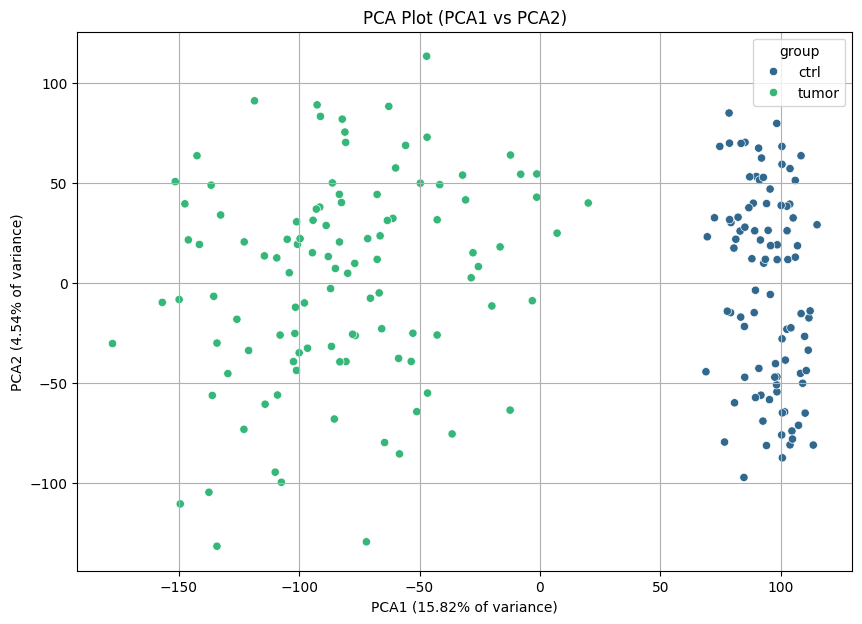

,PCA1,PCA2,group
0,106.909831,18.647101,ctrl
1,79.127035,-14.830302,ctrl
2,83.073833,26.008466,ctrl
3,80.513726,17.490536,ctrl
4,115.026522,29.163947,ctrl
...,...,...,...
197,-91.142362,83.414642,tumor
198,-83.077097,-39.457359,tumor
199,-58.328614,-85.557867,tumor
200,-134.083283,-30.067368,tumor


In [60]:
nc.visual.plot_pca(transcriptomics, transcriptomics_meta)

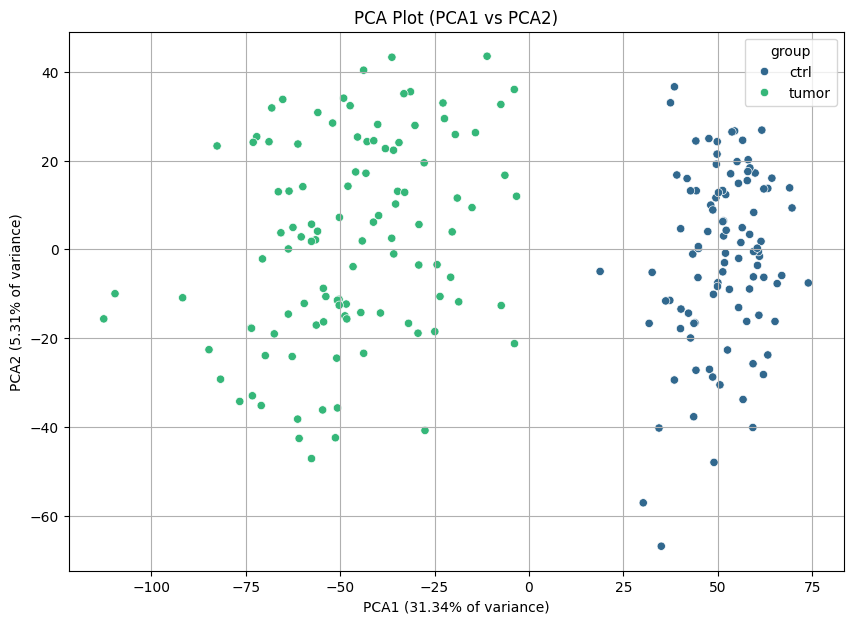

,PCA1,PCA2,group
0,43.622306,-37.733042,ctrl
1,44.305112,13.214271,ctrl
2,49.847993,24.287764,ctrl
3,59.430243,-6.199647,ctrl
4,48.995198,-48.026997,ctrl
...,...,...,...
202,-41.086690,24.496304,tumor
203,-51.976524,28.476896,tumor
204,-48.222467,-15.683685,tumor
205,-73.009733,24.133929,tumor


In [16]:
nc.visual.plot_pca(phosphoproteomics, phosphoproteomics_meta)

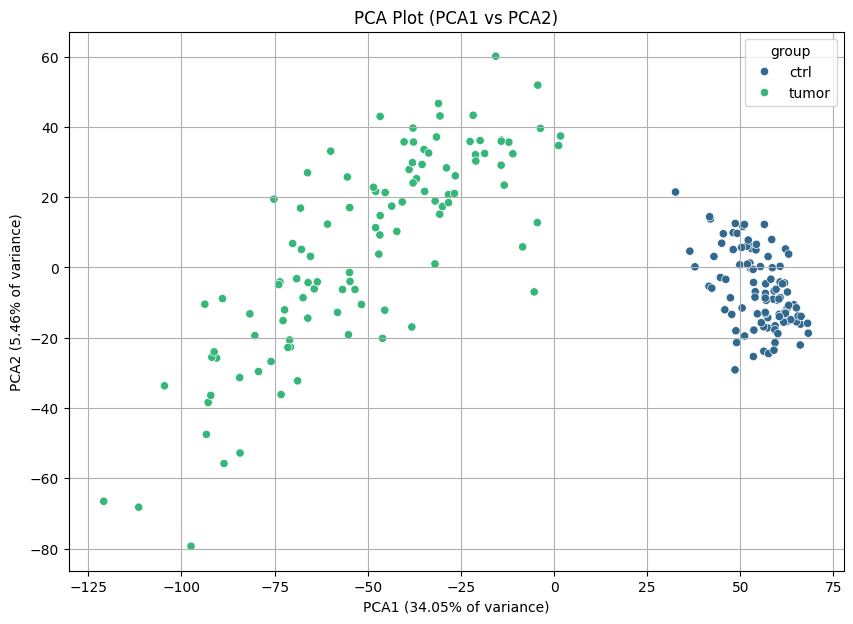

,PCA1,PCA2,group
0,56.460184,12.249547,ctrl
1,50.674229,11.655056,ctrl
2,58.424016,7.944417,ctrl
3,62.538869,-11.643726,ctrl
4,59.310804,-21.416599,ctrl
...,...,...,...
202,-48.453630,22.810067,tumor
203,-75.946722,-26.755746,tumor
204,-46.023526,-20.177156,tumor
205,-91.228312,-24.027183,tumor


In [17]:
nc.visual.plot_pca(proteomics, proteomics_meta)

And there are! We can easily differentiate the healthy and tumor tissues.

Now, since the data is indexed using ENSEMBL IDs, but our prior-knowledge network is in gene symbols, we will use the `get_ensembl_mappings()` and `convert_ensembl_to_gene_symbol()` to convert them.

In [18]:
ensembl_mapping = nc.data.omics.get_ensembl_mappings()

In [19]:
transcriptomics_renamed = nc.data.omics.convert_ensembl_to_gene_symbol(transcriptomics, ensembl_mapping)

Number of non-matched Ensembl IDs: 19731 (32.52%)
Number of summarized duplicated entries: 19787 (32.61%)


In [20]:
proteomics_renamed = nc.data.omics.convert_ensembl_to_gene_symbol(proteomics, ensembl_mapping)

Number of non-matched Ensembl IDs: 4 (0.04%)
Number of summarized duplicated entries: 4 (0.04%)


In [21]:
phospho_renamed = nc.data.omics.convert_ensembl_to_gene_symbol(phosphoproteomics, ensembl_mapping, summarisation='max')

Number of non-matched Ensembl IDs: 6 (0.07%)
Number of summarized duplicated entries: 5128 (59.07%)


Now, we can perform differential expression analysis with DESeq2.

In [22]:
de_transcr = nc.data.omics.deseq2(transcriptomics_renamed, transcriptomics_meta, ref_group='ctrl', test_group='tumor', feature_col='gene_symbol', sample_col='sample', round_values=True)

Fitting size factors...
... done in 0.21 seconds.

Fitting dispersions...
... done in 13.82 seconds.

Fitting dispersion trend curve...
/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.15 seconds.

Fitting MAP dispersions...
... done in 46.38 seconds.

Fitting LFCs...
... done in 10.29 seconds.

Calculating cook's distance...
... done in 0.54 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 4.80 seconds.



Log2 fold change & Wald test p-value: group tumor vs ctrl
              baseMean  log2FoldChange     lfcSE      stat        pvalue  \
gene_symbol                                                                
A1BG          4.742500        0.033628  0.094226  0.356882  7.211802e-01   
A1BG-AS1      7.340147       -0.079629  0.075575 -1.053649  2.920436e-01   
A1CF          3.119675        0.290504  0.117753  2.467060  1.362275e-02   
A2M          15.831610       -0.274551  0.051456 -5.335677  9.518893e-08   
A2M-AS1       7.674712       -0.285300  0.073876 -3.861859  1.125277e-04   
...                ...             ...       ...       ...           ...   
ZYG11B       11.223439       -0.064672  0.061131 -1.057921  2.900913e-01   
ZYX          11.118272       -0.108338  0.061389 -1.764769  7.760252e-02   
ZYXP1         0.000000             NaN       NaN       NaN           NaN   
ZZEF1        11.785252       -0.044394  0.059673 -0.743957  4.569025e-01   
ZZZ3         10.996321        

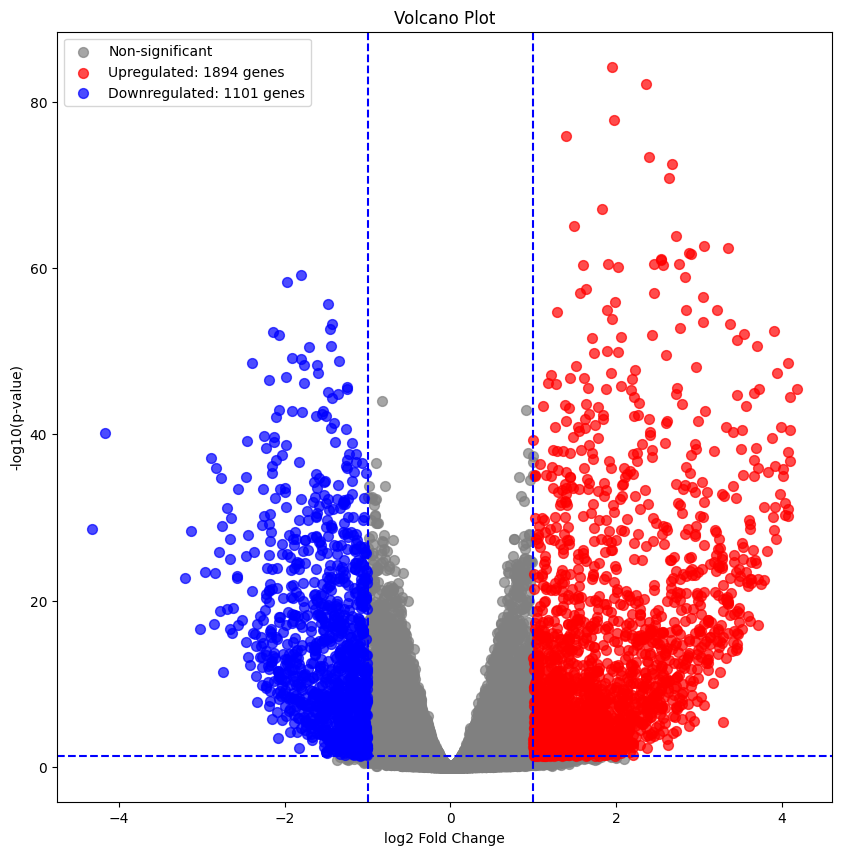

In [23]:
nc.visual.build_volcano_plot(data=de_transcr, log2fc='log2FoldChange', pval='padj')

In [24]:
de_prot = nc.data.omics.deseq2(proteomics_renamed, proteomics_meta, ref_group='ctrl', test_group='tumor', feature_col='gene_symbol', sample_col='sample', round_values=True)

Fitting size factors...
... done in 0.09 seconds.

Fitting dispersions...
... done in 6.47 seconds.

Fitting dispersion trend curve...
/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.30 seconds.

/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Fitting MAP dispersions...
/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-

Log2 fold change & Wald test p-value: group tumor vs ctrl
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene_symbol                                                                   
A1BG         28.680311       -0.056978  0.037471 -1.520619  0.128355  0.999779
A2M          30.319057       -0.081396  0.036438 -2.233837  0.025494  0.899615
A2ML1        24.020306        0.075093  0.041032  1.830124  0.067231  0.999779
AAAS         24.126653        0.012712  0.040889  0.310897  0.755879  0.999779
AACS         24.677737        0.051569  0.040460  1.274565  0.202463  0.999779
...                ...             ...       ...       ...       ...       ...
ZXDC         21.516271        0.051633  0.043331  1.191601  0.233418  0.999779
ZYG11B       22.695789       -0.035193  0.042131 -0.835325  0.403535  0.999779
ZYX          28.806004       -0.034987  0.037397 -0.935574  0.349492  0.999779
ZZEF1        25.020953       -0.000616  0.040143 -0.015336  0.987764  0.9

... done in 0.95 seconds.



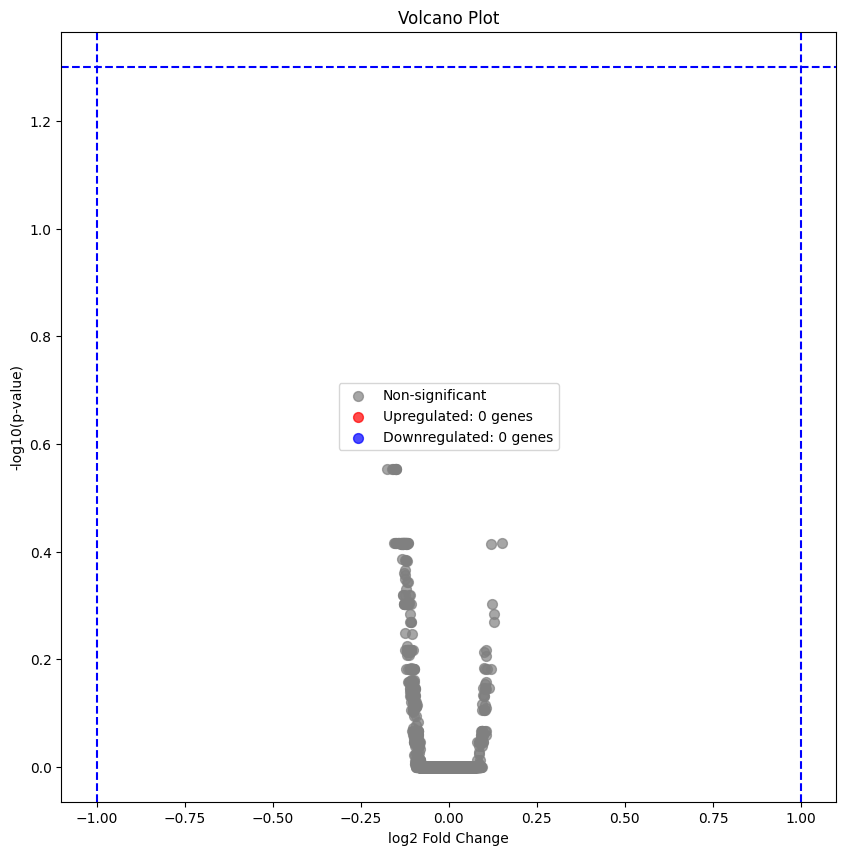

In [25]:
nc.visual.build_volcano_plot(data=de_prot, log2fc='log2FoldChange', pval='padj')

In [26]:
de_phospho = nc.data.omics.deseq2(phospho_renamed, phosphoproteomics_meta, ref_group='ctrl', test_group='tumor', feature_col='gene_symbol', sample_col='sample', round_values=True)

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 2.24 seconds.

Fitting dispersion trend curve...
/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.14 seconds.

/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Fitting MAP dispersions...
/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-

Log2 fold change & Wald test p-value: group tumor vs ctrl
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene_symbol                                                                   
AAAS         24.755425        0.063898  0.040391  1.581984  0.113653  0.502252
AAK1         26.228863        0.026919  0.039210  0.686526  0.492381  0.875153
AAMDC        22.288849       -0.053229  0.042488 -1.252798  0.210279  0.672683
AATF         21.249186        0.093190  0.043628  2.136021  0.032678  0.253317
ABCA1        22.355326        0.037716  0.042480  0.887847  0.374623  0.799516
...                ...             ...       ...       ...       ...       ...
ZSCAN29      21.819184        0.053998  0.043013  1.255389  0.209338  0.671052
ZSWIM8       24.823590        0.000301  0.040286  0.007472  0.994038  0.998048
ZYX          27.954683       -0.089015  0.037930 -2.346815  0.018935  0.187918
ZZEF1        23.360520       -0.026850  0.041513 -0.646774  0.517778  0.8

... done in 0.40 seconds.



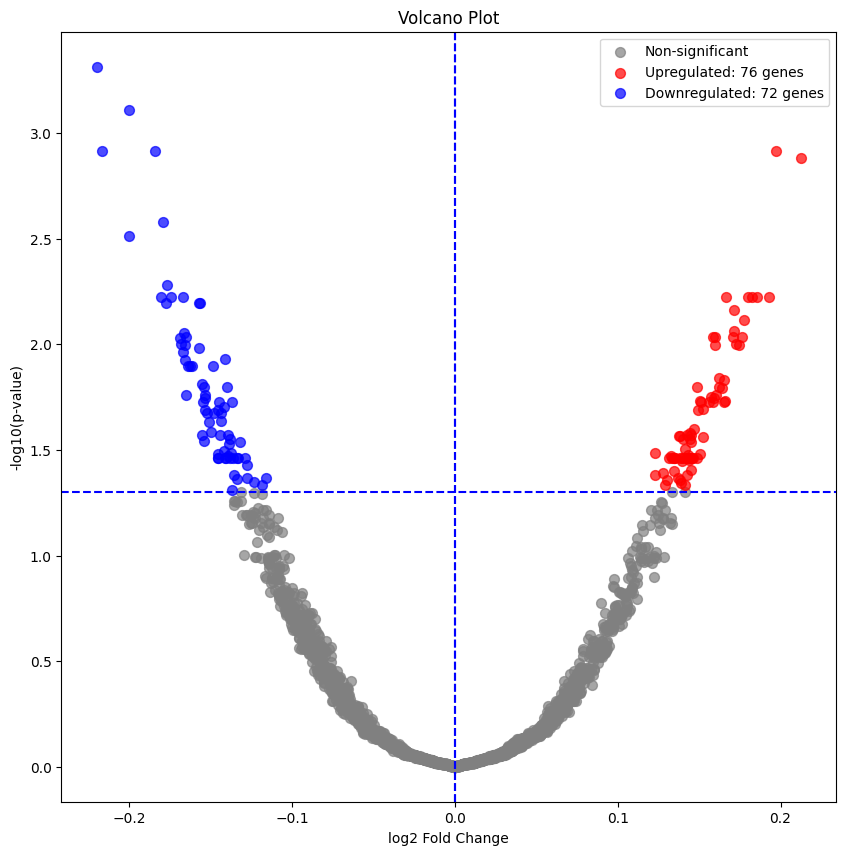

In [58]:
nc.visual.build_volcano_plot(data=de_phospho, log2fc='log2FoldChange', pval='padj', log2fc_threshold=0)

## 2. Prior knowledge and inputs

Now that we have our data preprocessed, we can proceed to defining the inputs of the network inference methods. For the upstream layer, we will identify the most abundant receptors (using information from LIANA) in the proteome. For the downstream layer, we will perform TF activity estimation using the transcriptomics data.

In [28]:
liana_receptors = nc.data.network.get_lianaplus()

In [29]:
receptors = set(liana_receptors.target)

In [30]:
receptors_prot = de_prot[de_prot.index.isin(receptors)]

top_receptors = receptors_prot.sort_values(by='stat', key=lambda x: x.abs(), ascending=False).head(5)

In [31]:
top_receptors

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
CCBE1,21.066737,-0.174563,0.043714,-3.993273,0.000065,0.279942
ACKR3,18.925230,0.151665,0.046328,3.273738,0.001061,0.384288
CAV1,29.096061,-0.121249,0.037191,-3.260141,0.001114,0.384288
AGER,28.719002,-0.120221,0.037435,-3.211485,0.001321,0.384288
CD36,25.557545,-0.127201,0.039683,-3.205461,0.001348,0.384288


In [32]:
source_dict = top_receptors['stat'].to_dict()

In [34]:
import decoupler as dc
collectri = dc.get_collectri()

In [35]:
de_transcr.dropna(inplace=True)
decoupler_input = nc.utils.decoupler_formatter(de_transcr, 'stat')
dc_estimates, dc_pvals = dc.run_ulm(decoupler_input, collectri)
measurements = nc.utils.targetlayer_formatter(dc_estimates.T)

Now that we have our inputs, we can get the network from OmniPath.

In [40]:
network = nc.data.network.get_omnipath()

In [41]:
graph = nc.utils.network_from_df(network)

Now, we can perform network inference using basic topological methods. We will store the network in a dictionary to ease further downstream analysis.

In [42]:
networks = {}

In [43]:
networks['shortest_path'], shortest_paths_list = nc.methods.run_shortest_paths(graph, source_dict, measurements)

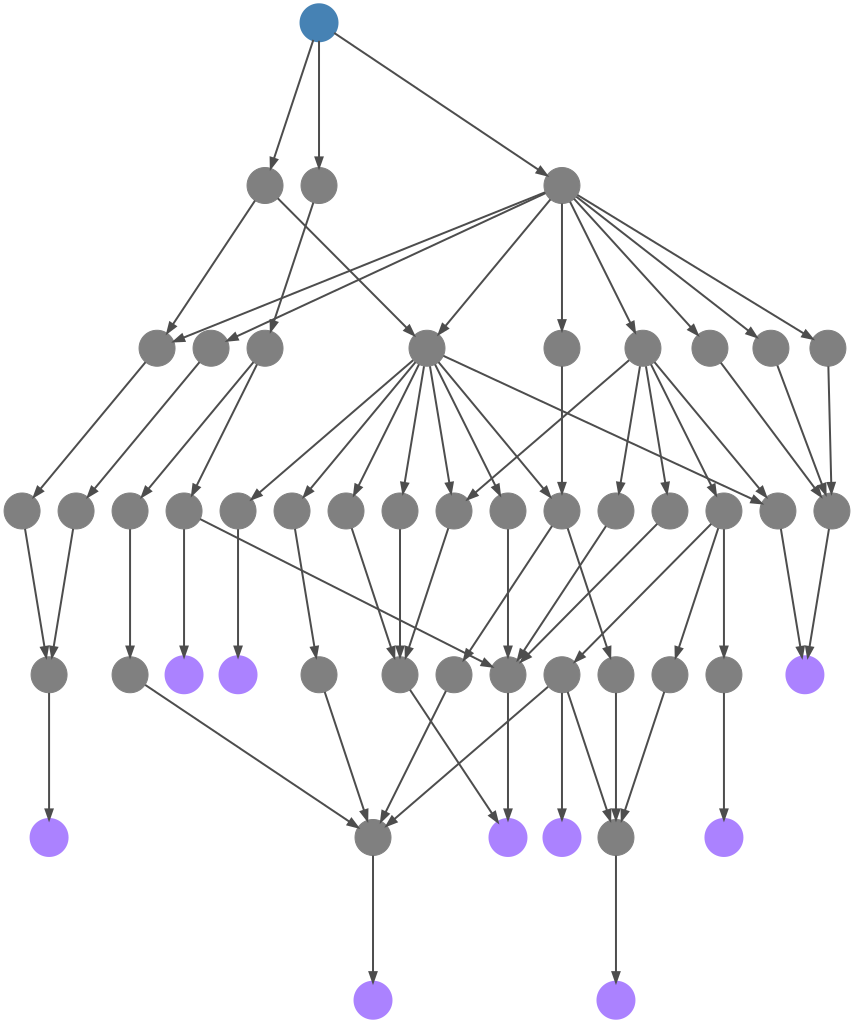

In [44]:
from IPython.display import HTML, display
a = nc.visual.visualize_graph_simple(networks['shortest_path'], source_dict, measurements, is_sign_consistent=False)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

In [45]:
networks['shortest_sc_path'], shortest_sc_list = nc.methods.run_sign_consistency(networks['shortest_path'], shortest_paths_list, source_dict, measurements)

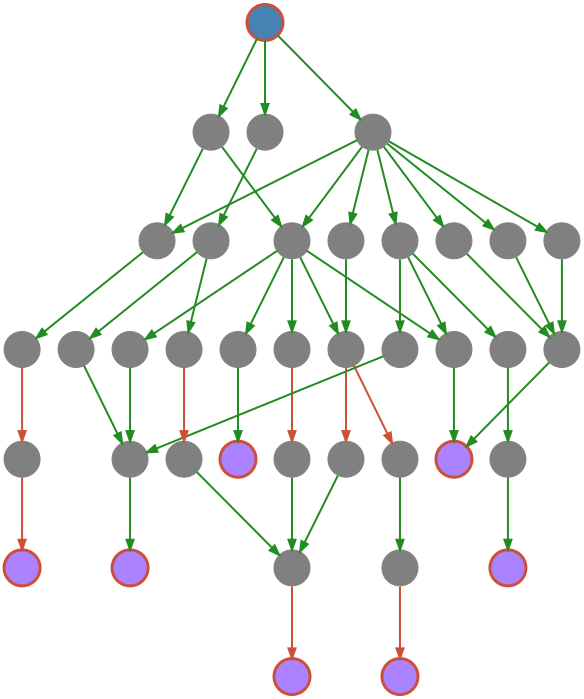

In [46]:
from IPython.display import HTML, display
a = nc.visual.visualize_graph_simple(networks['shortest_sc_path'], source_dict, measurements, is_sign_consistent=True)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

In [47]:
networks['all_paths'], all_paths_list = nc.methods.run_all_paths(graph, source_dict, measurements, depth_cutoff=6)

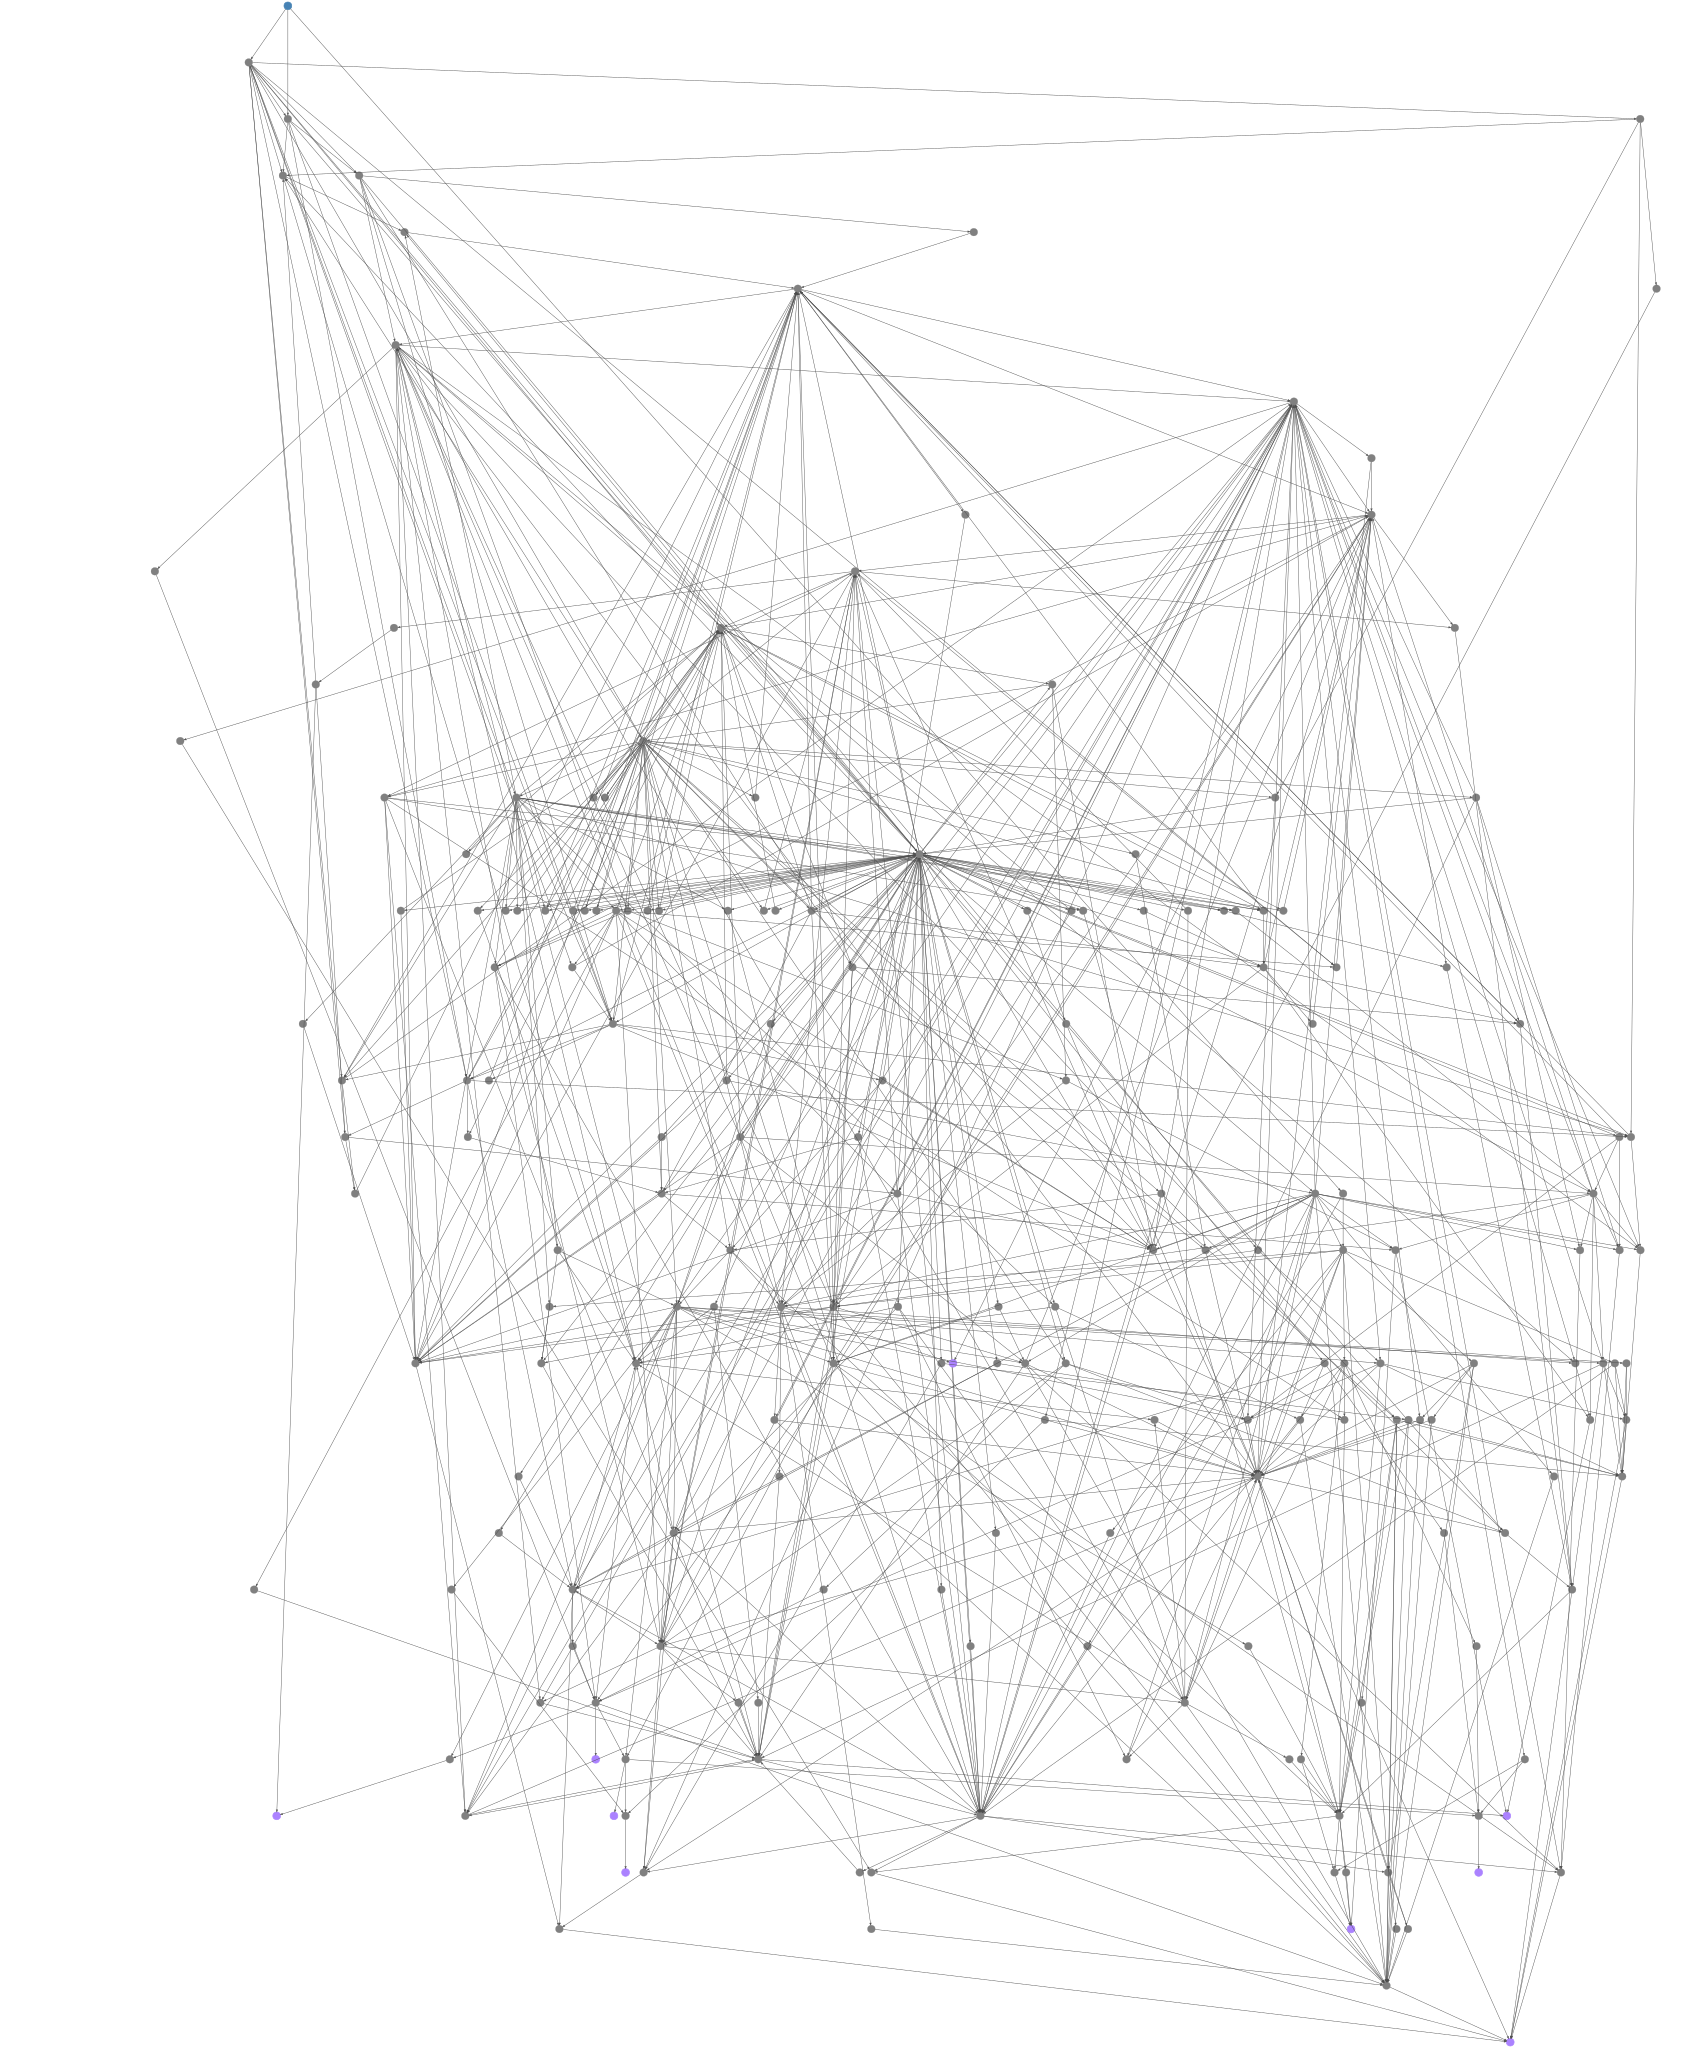

In [48]:
from IPython.display import HTML, display
a = nc.visual.visualize_graph_simple(networks['all_paths'], source_dict, measurements, is_sign_consistent=False)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

In [49]:
networks['all_sc_paths'], allpaths_sc_list = nc.methods.run_sign_consistency(networks['all_paths'], all_paths_list, source_dict, measurements)

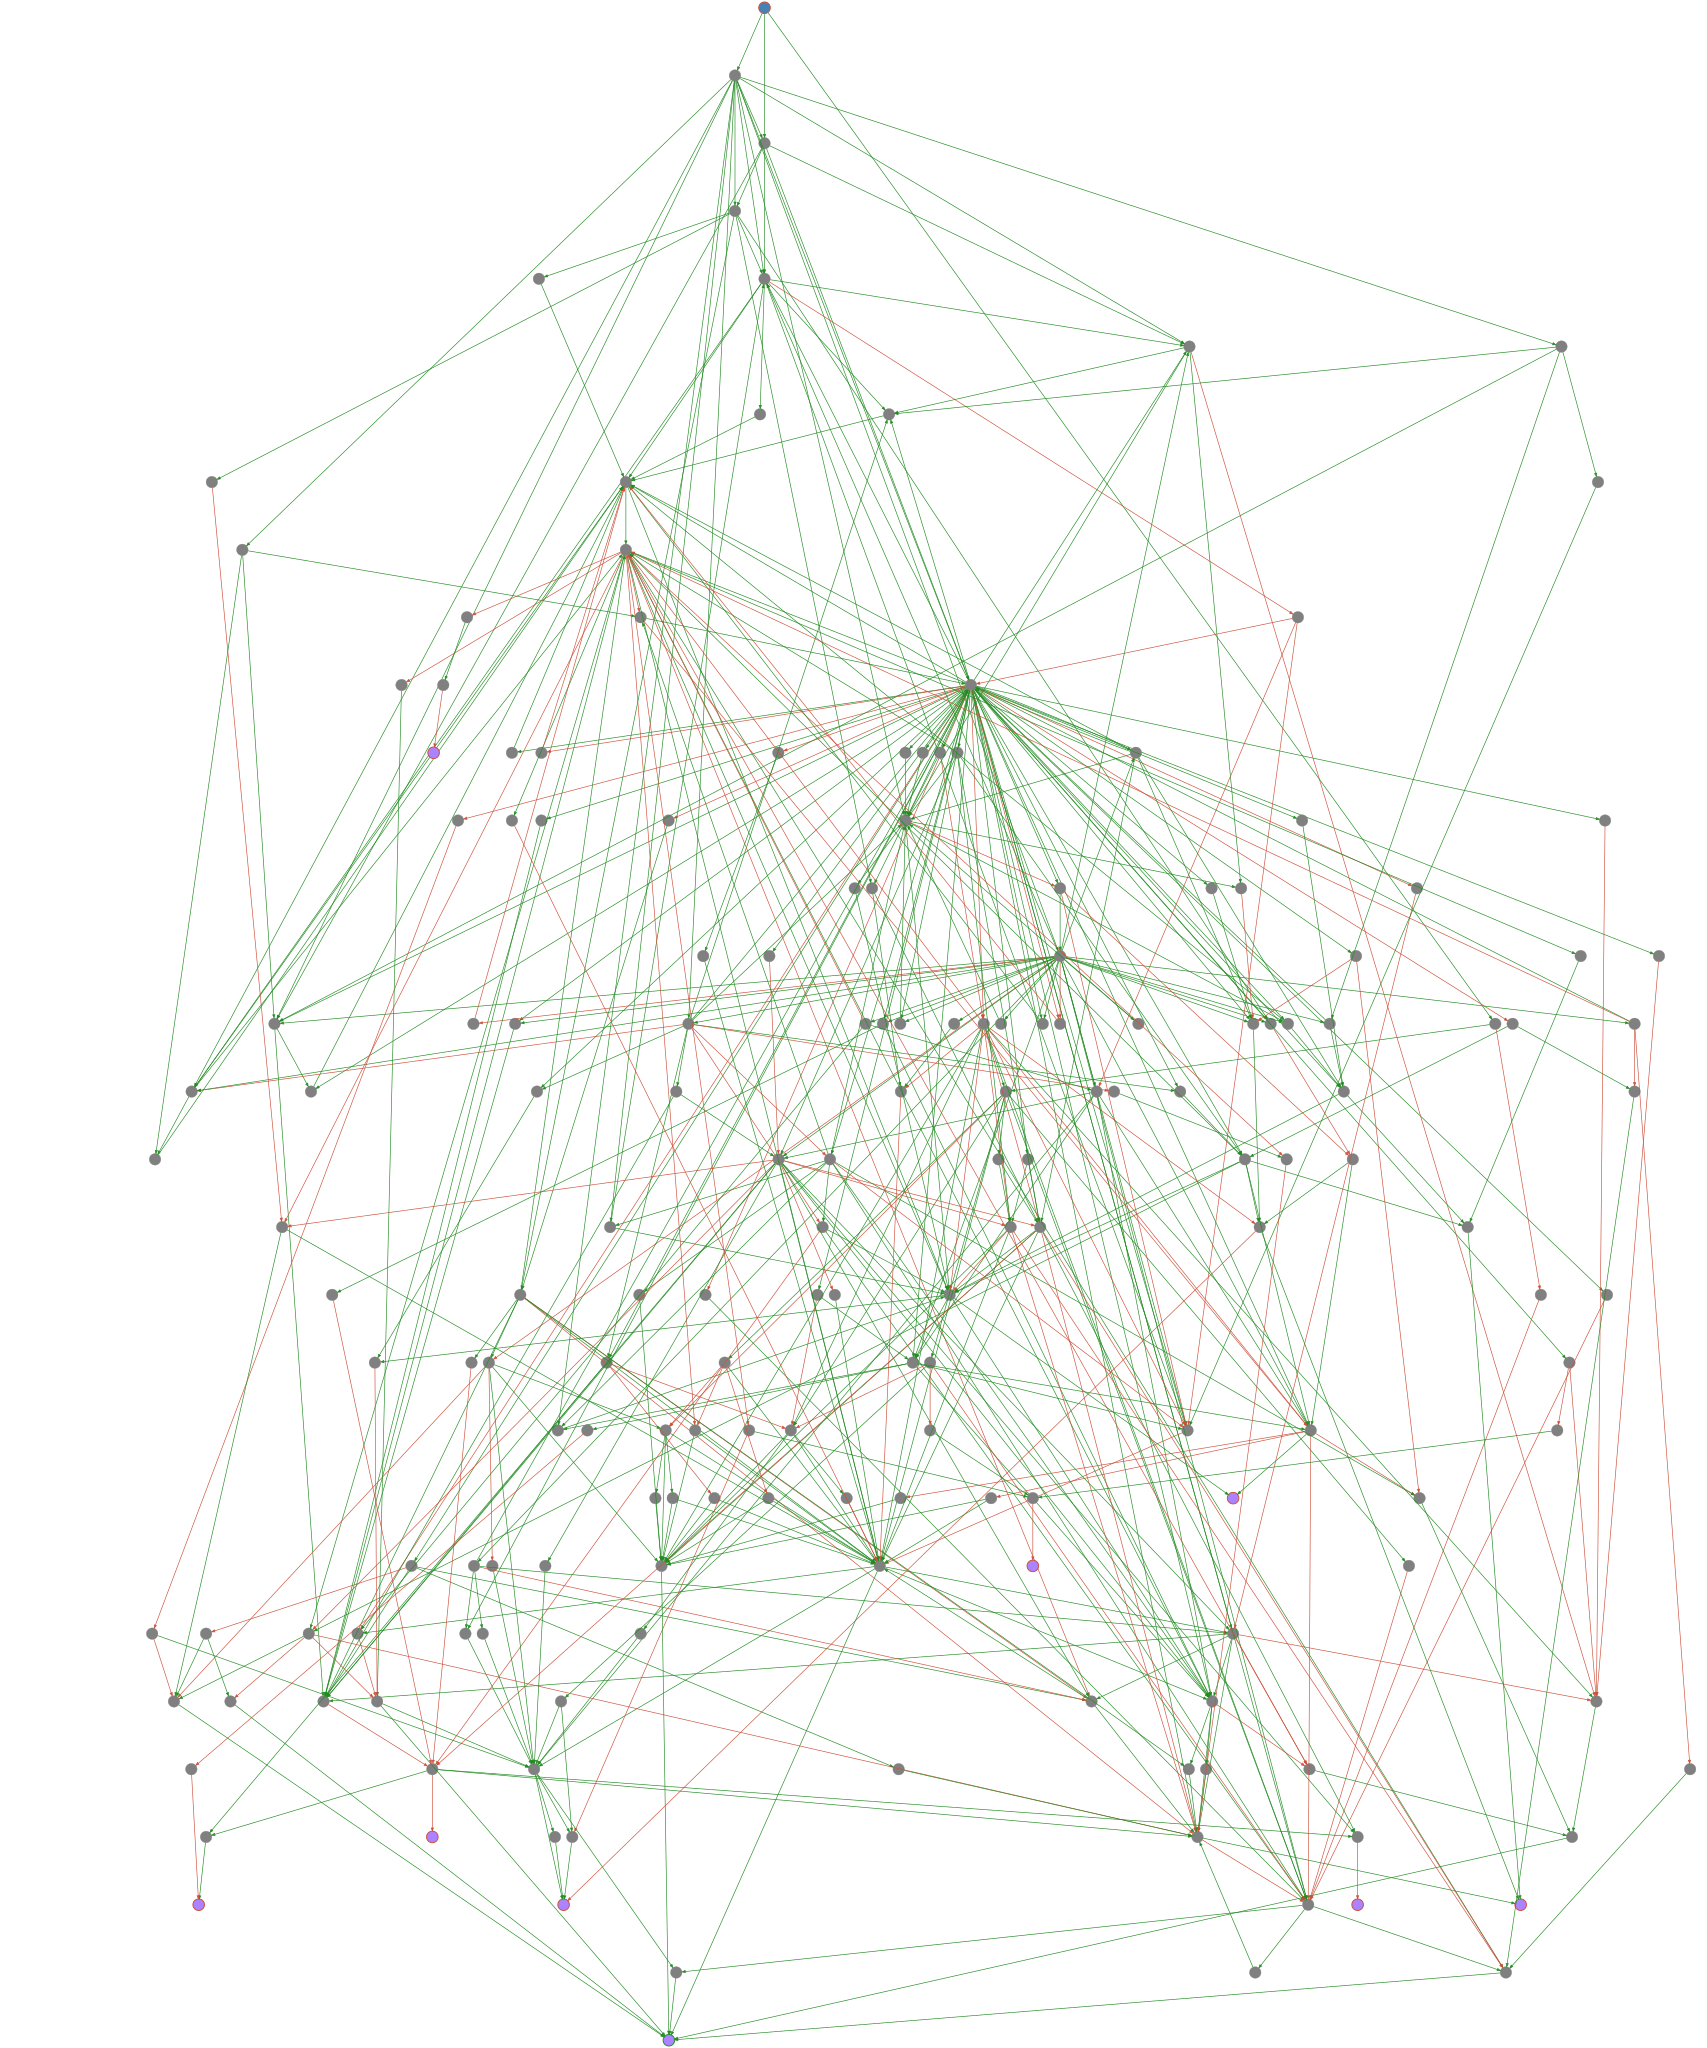

In [50]:
from IPython.display import HTML, display
a = nc.visual.visualize_graph_simple(networks['all_sc_paths'], source_dict, measurements, is_sign_consistent=True)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

## 3. Network evaluation using level of dysregulation in the phosphoproteome.

In [51]:
sp_random_controls = nc.eval.perform_random_controls(graph, nc.methods.run_shortest_paths, 10, 'shortest_path', source_dict=source_dict, target_dict=measurements)

In [52]:
ap_random_controls = nc.eval.perform_random_controls(graph, nc.methods.run_all_paths, 10, 'all_paths', source_dict=source_dict, target_dict=measurements, depth_cutoff=6)

In [53]:
combined_dict = {}
combined_dict.update(networks)
combined_dict.update(sp_random_controls)
combined_dict.update(ap_random_controls)
combined_dict

{'shortest_path': <networkx.classes.digraph.DiGraph at 0x7f157e821ba0>,
 'shortest_sc_path': <networkx.classes.digraph.DiGraph at 0x7f155afeeaa0>,
 'all_paths': <networkx.classes.digraph.DiGraph at 0x7f1551aaffd0>,
 'all_sc_paths': <networkx.classes.digraph.DiGraph at 0x7f1551d2b340>,
 'shortest_path__random001': <networkx.classes.digraph.DiGraph at 0x7f155afeee00>,
 'shortest_path__random002': <networkx.classes.digraph.DiGraph at 0x7f155afeea70>,
 'shortest_path__random003': <networkx.classes.digraph.DiGraph at 0x7f157e214610>,
 'shortest_path__random004': <networkx.classes.digraph.DiGraph at 0x7f157e77e470>,
 'shortest_path__random005': <networkx.classes.digraph.DiGraph at 0x7f155afee6e0>,
 'shortest_path__random006': <networkx.classes.digraph.DiGraph at 0x7f157e1c1ff0>,
 'shortest_path__random007': <networkx.classes.digraph.DiGraph at 0x7f1551d2be50>,
 'shortest_path__random008': <networkx.classes.digraph.DiGraph at 0x7f157e2144c0>,
 'shortest_path__random009': <networkx.classes.dig

In [54]:
phospho_results = nc.eval.get_metric_from_networks(combined_dict, nc.eval.get_phosphorylation_status, dataframe=de_phospho)

/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide


In [55]:
phospho_results

,avg_relabundance,avg_relabundance_overall,diff_avg_abundance,nodes_with_phosphoinfo,coverage,network,type,method
0,-0.270619,-0.00868,0.263870,26,52.000000,shortest_path,real,shortest_path
1,-0.028841,-0.00868,0.020280,21,53.846154,shortest_sc_path,real,shortest_sc_path
2,-0.409875,-0.00868,0.406458,104,52.261307,all_paths,real,all_paths
3,-0.527950,-0.00868,0.522210,96,53.333333,all_sc_paths,real,all_sc_paths
4,0.304632,-0.00868,0.294979,11,40.740741,shortest_path__random001,random,shortest_path
5,0.959182,-0.00868,0.946673,14,26.923077,shortest_path__random002,random,shortest_path
6,-0.175226,-0.00868,0.167347,17,24.285714,shortest_path__random003,random,shortest_path
7,NaN,-0.00868,NaN,0,0.000000,shortest_path__random004,random,shortest_path
8,-0.171629,-0.00868,0.164104,25,30.120482,shortest_path__random005,random,shortest_path
9,-0.109794,-0.00868,0.101917,28,30.434783,shortest_path__random006,random,shortest_path


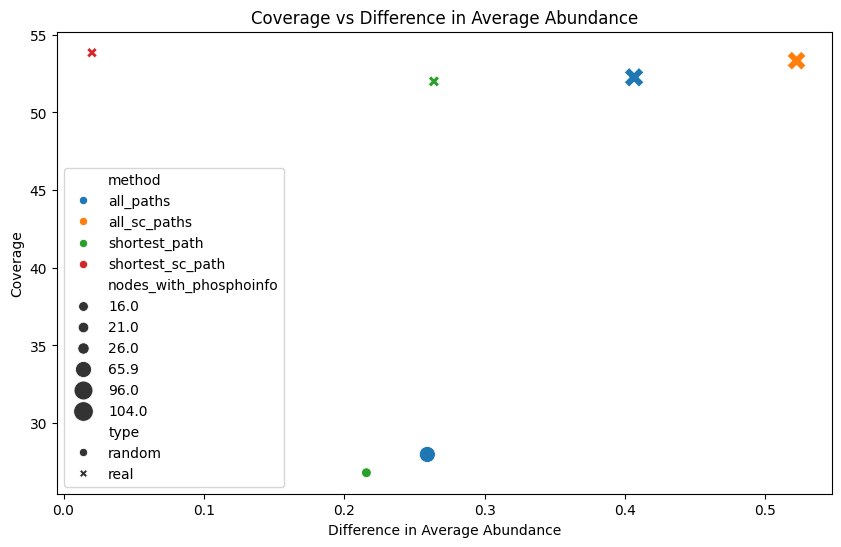

In [56]:
nc.visual.plot_scatter(phospho_results)

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot violin plots for each column in random_columns
plt.figure(figsize=(12, 6))
sns.violinplot(data=random_columns)
plt.title('Violin Plots per Column')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


NameError: name 'random_columns' is not defined

<Figure size 1200x600 with 0 Axes>

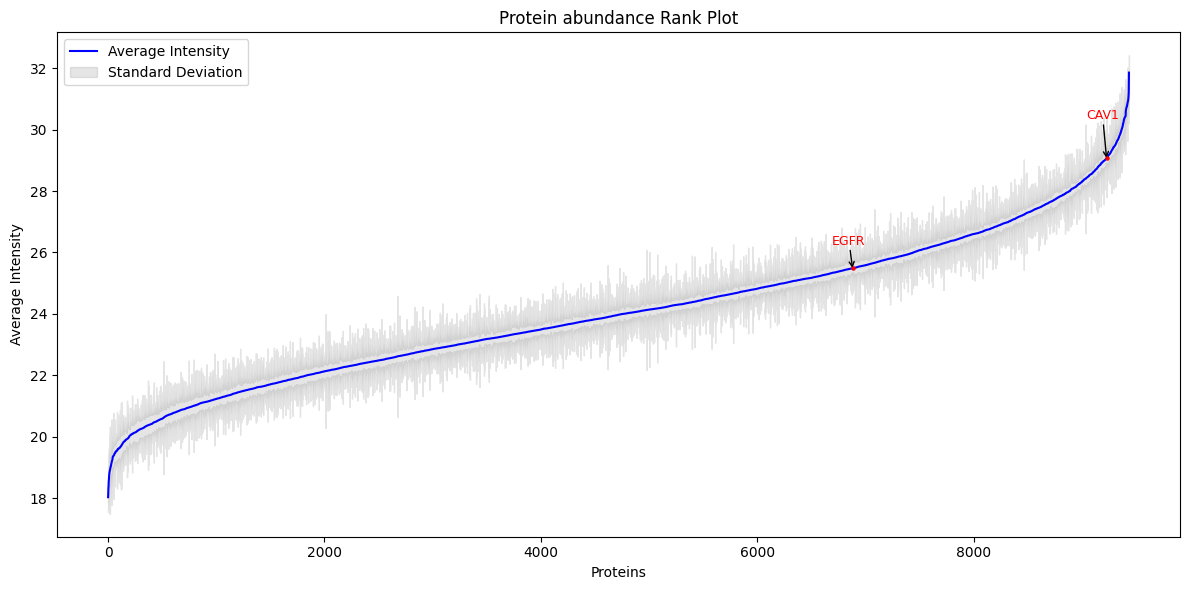

In [ ]:
nc.visual.plot_rank(proteomics_renamed, bio_ids=['CAV1', 'EGFR'], id_column='gene_symbol')

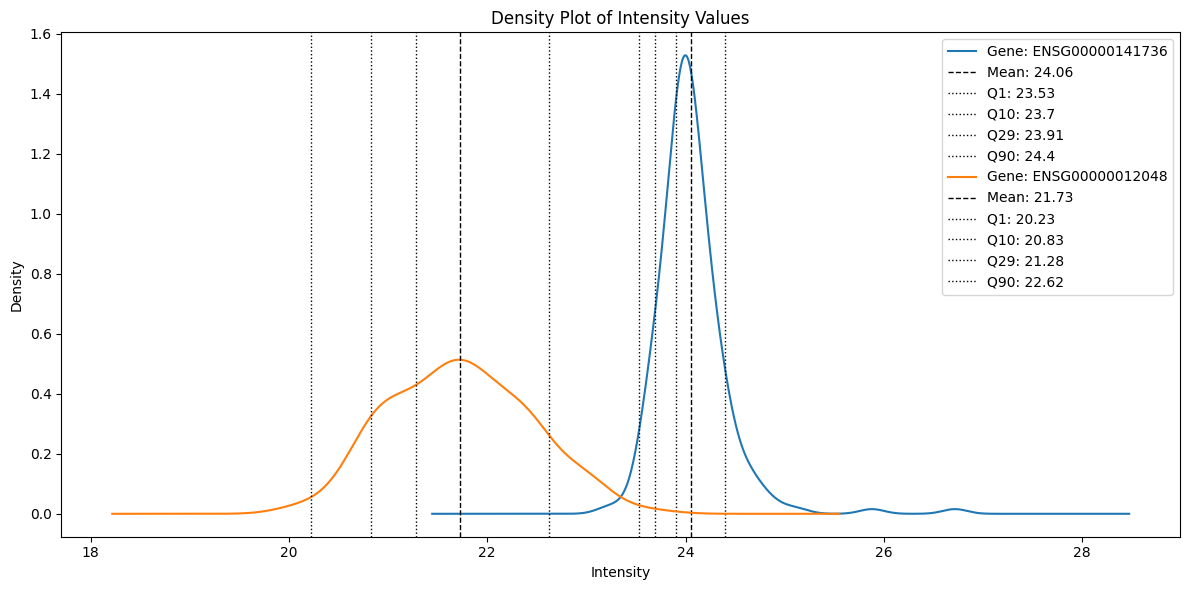

In [ ]:
nc.visual.plot_density(proteomics, ['ENSG00000141736', 'ENSG00000012048'])